In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


In [12]:
data = pd.read_csv('dataset_limpio.csv')

In [13]:
print(f" Dataset cargado: {len(data):,} registros")
print(f" Periodo: {data['year'].min()} - {data['year'].max()}")
print(f" latitudes: {data['latitud'].min()} - {data['latitud'].max()}")
print(f" latitudes: {data['longitud'].min()} - {data['longitud'].max()}")
print("head")
print(data[['latitud', 'longitud', 'year', 'month', 'hour']].tail())

 Dataset cargado: 284,007 registros
 Periodo: 2003 - 2022
 latitudes: 6.15252386 - 6.37259133
 latitudes: -75.71146237 - -75.50002384
head
         latitud   longitud  year  month  hour
284002  6.210747 -75.594824  2022     12     1
284003  6.210747 -75.594824  2022     12     1
284004  6.277843 -75.548814  2022     12     2
284005  6.263810 -75.555418  2022     12     5
284006  6.255104 -75.563336  2022     12     8


In [14]:
latitud_max = 6.37
latitud_min = 6.15

longitud_max = -75.50
longitud_min = -75.71

# 2️⃣ Tamaño de la celda en grados (aprox 500 m)
cell_size = 0.0045  # 500 metros ≈ 0.0045 grados

# 3️⃣ Crear secuencias de coordenadas
latitudes = np.arange(latitud_min, latitud_max, cell_size)
longitudes = np.arange(longitud_min, longitud_max, cell_size)

# 4️⃣ Crear producto cartesiano para todas las celdas
grid = []
celda_id = 1

for lat in latitudes:
    for lon in longitudes:
        grid.append({
            'celda_id': celda_id,
            'lat_min': lat,
            'lat_max': lat + cell_size,
            'lon_min': lon,
            'lon_max': lon + cell_size,
            'lat_centro': lat + (cell_size / 2),
            'lon_centro': lon + (cell_size / 2),
            'area_km2': round((cell_size * 111) ** 2, 4) 
        })
        celda_id += 1

# 5️⃣ Crear DataFrame
grid_df = pd.DataFrame(grid)

# 6️⃣ Mostrar resultado
print(grid_df.head())
print(f"\nTotal de celdas generadas: {len(grid_df)}")

# 7️⃣ (Opcional) Guardar cuadrícula
grid_df.to_csv("cuadricula_medellin_500m.csv", index=False)


   celda_id  lat_min  lat_max  lon_min  lon_max  lat_centro  lon_centro  \
0         1     6.15   6.1545 -75.7100 -75.7055     6.15225   -75.70775   
1         2     6.15   6.1545 -75.7055 -75.7010     6.15225   -75.70325   
2         3     6.15   6.1545 -75.7010 -75.6965     6.15225   -75.69875   
3         4     6.15   6.1545 -75.6965 -75.6920     6.15225   -75.69425   
4         5     6.15   6.1545 -75.6920 -75.6875     6.15225   -75.68975   

   area_km2  
0    0.2495  
1    0.2495  
2    0.2495  
3    0.2495  
4    0.2495  

Total de celdas generadas: 2303


In [15]:
hurtos = pd.read_csv("dataset_limpio.csv")
grid = pd.read_csv("cuadricula_medellin_500m.csv")

print(f"Hurtos totales: {len(hurtos)}")
print(f"Celdas en la cuadrícula: {len(grid)}")

# 2️⃣ Crear columnas auxiliares para facilitar el merge
# Calcular el índice de celda basado en las coordenadas
cell_size = 0.0045

# Referencia: límites originales
latitud_min = 6.15
longitud_min = -75.71

# Asignar índices de fila y columna a cada hurto
hurtos['fila'] = ((hurtos['latitud'] - latitud_min) / cell_size).astype(int)
hurtos['columna'] = ((hurtos['longitud'] - longitud_min) / cell_size).astype(int)

# Asignar índices de fila y columna a cada celda
grid['fila'] = ((grid['lat_min'] - latitud_min) / cell_size).astype(int)
grid['columna'] = ((grid['lon_min'] - longitud_min) / cell_size).astype(int)

# 3️⃣ Hacer merge por índices (mucho más rápido)
hurtos = hurtos.merge(
    grid[['celda_id', 'fila', 'columna', 'lat_centro', 'lon_centro']], 
    on=['fila', 'columna'], 
    how='left'
)

# 4️⃣ Limpiar columnas auxiliares
hurtos = hurtos.drop(['fila', 'columna'], axis=1)

# 5️⃣ Verificar asignación
hurtos_sin_celda = hurtos['celda_id'].isna().sum()
print(f"\n⚠️ Hurtos sin celda asignada: {hurtos_sin_celda}")

# 6️⃣ Filtrar solo los que tienen celda
hurtos_validos = hurtos.dropna(subset=['celda_id'])

# 7️⃣ Guardar
hurtos_validos.to_csv("hurtos_con_celda.csv", index=False)

# 8️⃣ Mostrar resultado
print("\n📊 Muestra de datos:")
print(hurtos_validos[['latitud', 'longitud', 'celda_id', 'lat_centro', 'lon_centro']].head(10))
print(f"\n✅ Total de hurtos asignados: {len(hurtos_validos)}")
print(f"❌ Hurtos descartados (fuera del área): {len(hurtos) - len(hurtos_validos)}")

Hurtos totales: 284007
Celdas en la cuadrícula: 2303

⚠️ Hurtos sin celda asignada: 177

📊 Muestra de datos:
    latitud   longitud  celda_id  lat_centro  lon_centro
0  6.299703 -75.582016    1581.0     6.30075   -75.57725
1  6.250917 -75.566160    1067.0     6.25125   -75.56375
2  6.274836 -75.554909    1305.0     6.27375   -75.55025
3  6.276236 -75.553533    1352.0     6.27825   -75.55025
4  6.250339 -75.586914    1063.0     6.25125   -75.58175
5  6.219071 -75.602996     730.0     6.21975   -75.59975
6  6.317709 -75.678259    1748.0     6.31875   -75.67175
7  6.268307 -75.558457    1257.0     6.26925   -75.55475
8  6.242797 -75.554797     976.0     6.24225   -75.55025
9  6.246823 -75.562114    1021.0     6.24675   -75.55925

✅ Total de hurtos asignados: 283838
❌ Hurtos descartados (fuera del área): 177


In [16]:
# Análisis de patrones por celda
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Cargar datos con celdas asignadas
hurtos_con_celda = pd.read_csv("hurtos_con_celda.csv")
grid = pd.read_csv("cuadricula_medellin_500m.csv")

print("=== ANÁLISIS DE PATRONES POR CELDA ===")
print(f"Hurtos con celda asignada: {len(hurtos_con_celda):,}")
print(f"Total de celdas en la cuadrícula: {len(grid):,}")

# Contar hurtos por celda
hurtos_por_celda = hurtos_con_celda.groupby('celda_id').agg({
    'latitud': 'count',  # Total de hurtos
    'hour': ['mean', 'std'],  # Hora promedio y desviación
    'dayofweek': 'mean',  # Día de la semana promedio
    'edad': 'mean',  # Edad promedio de víctimas
    'modalidad': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0,  # Modalidad más común
    'lugar': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0,  # Lugar más común
    'year': ['min', 'max'],  # Rango de años
    'month': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0  # Mes más común
}).round(2)

# Aplanar nombres de columnas
hurtos_por_celda.columns = ['total_hurtos', 'hora_promedio', 'hora_std', 'dia_promedio', 
                           'edad_promedio', 'modalidad_comun', 'lugar_comun', 
                           'año_inicio', 'año_fin', 'mes_comun']

# Agregar información geográfica
hurtos_por_celda = hurtos_por_celda.merge(
    grid[['celda_id', 'lat_centro', 'lon_centro', 'area_km2']], 
    on='celda_id', 
    how='left'
)

# Calcular densidad de hurtos (hurtos por km²)
hurtos_por_celda['densidad_hurtos'] = hurtos_por_celda['total_hurtos'] / hurtos_por_celda['area_km2']

print(f"\nCeldas con al menos 1 hurto: {len(hurtos_por_celda):,}")
print(f"Celdas sin hurtos: {len(grid) - len(hurtos_por_celda):,}")

# Estadísticas básicas
print(f"\n=== ESTADÍSTICAS DE HURTOS POR CELDA ===")
print(f"Promedio de hurtos por celda: {hurtos_por_celda['total_hurtos'].mean():.2f}")
print(f"Máximo de hurtos en una celda: {hurtos_por_celda['total_hurtos'].max()}")
print(f"Desviación estándar: {hurtos_por_celda['total_hurtos'].std():.2f}")

# Guardar análisis por celda
hurtos_por_celda.to_csv("resumen_hurtos_por_celda.csv", index=False)
print(f"\n✅ Datos guardados en 'resumen_hurtos_por_celda.csv'")


=== ANÁLISIS DE PATRONES POR CELDA ===
Hurtos con celda asignada: 283,838
Total de celdas en la cuadrícula: 2,303

Celdas con al menos 1 hurto: 844
Celdas sin hurtos: 1,459

=== ESTADÍSTICAS DE HURTOS POR CELDA ===
Promedio de hurtos por celda: 336.30
Máximo de hurtos en una celda: 17826
Desviación estándar: 957.32

✅ Datos guardados en 'resumen_hurtos_por_celda.csv'


In [17]:
# SISTEMA DE SCORING DE RIESGO POR CELDA
from scipy import stats
import numpy as np

def calcular_score_riesgo(celda_data, percentiles_globales):
    """
    Calcula un score de riesgo para una celda basado en múltiples factores
    """
    score = 0
    
    # 1. Factor de frecuencia (40% del peso)
    total_hurtos = celda_data['total_hurtos']
    if total_hurtos > 0:
        # Normalizar por percentiles globales
        if total_hurtos >= percentiles_globales['hurtos_p95']:
            score += 40
        elif total_hurtos >= percentiles_globales['hurtos_p75']:
            score += 30
        elif total_hurtos >= percentiles_globales['hurtos_p50']:
            score += 20
        else:
            score += 10
    
    # 2. Factor de densidad (25% del peso)
    densidad = celda_data['densidad_hurtos']
    if densidad >= percentiles_globales['densidad_p90']:
        score += 25
    elif densidad >= percentiles_globales['densidad_p75']:
        score += 20
    elif densidad >= percentiles_globales['densidad_p50']:
        score += 15
    else:
        score += 5
    
    # 3. Factor temporal - concentración en horarios (20% del peso)
    hora_std = celda_data['hora_std']
    if hora_std <= 2:  # Muy concentrado en horarios específicos
        score += 20
    elif hora_std <= 4:
        score += 15
    elif hora_std <= 6:
        score += 10
    else:
        score += 5
    
    # 4. Factor de recencia (15% del peso)
    años_actividad = celda_data['año_fin'] - celda_data['año_inicio'] + 1
    if años_actividad >= 10:  # Actividad sostenida
        score += 15
    elif años_actividad >= 5:
        score += 10
    else:
        score += 5
    
    return min(score, 100)  # Cap en 100

# Calcular percentiles globales para normalización
percentiles_globales = {
    'hurtos_p50': hurtos_por_celda['total_hurtos'].quantile(0.5),
    'hurtos_p75': hurtos_por_celda['total_hurtos'].quantile(0.75),
    'hurtos_p95': hurtos_por_celda['total_hurtos'].quantile(0.95),
    'densidad_p50': hurtos_por_celda['densidad_hurtos'].quantile(0.5),
    'densidad_p75': hurtos_por_celda['densidad_hurtos'].quantile(0.75),
    'densidad_p90': hurtos_por_celda['densidad_hurtos'].quantile(0.90)
}

print("=== PERCENTILES GLOBALES PARA NORMALIZACIÓN ===")
for key, value in percentiles_globales.items():
    print(f"{key}: {value:.2f}")

# Aplicar scoring a todas las celdas
hurtos_por_celda['score_riesgo'] = hurtos_por_celda.apply(
    lambda row: calcular_score_riesgo(row, percentiles_globales), axis=1
)

# Clasificar niveles de riesgo
def clasificar_riesgo(score):
    if score >= 80:
        return 'MUY_ALTO'
    elif score >= 60:
        return 'ALTO'
    elif score >= 40:
        return 'MEDIO'
    elif score >= 20:
        return 'BAJO'
    else:
        return 'MUY_BAJO'

hurtos_por_celda['nivel_riesgo'] = hurtos_por_celda['score_riesgo'].apply(clasificar_riesgo)

# Estadísticas del scoring
print(f"\n=== DISTRIBUCIÓN DE RIESGO ===")
distribucion = hurtos_por_celda['nivel_riesgo'].value_counts()
for nivel, count in distribucion.items():
    porcentaje = (count / len(hurtos_por_celda)) * 100
    print(f"{nivel}: {count} celdas ({porcentaje:.1f}%)")

print(f"\nScore promedio: {hurtos_por_celda['score_riesgo'].mean():.2f}")
print(f"Score máximo: {hurtos_por_celda['score_riesgo'].max():.2f}")

# Guardar datos con scoring
hurtos_por_celda.to_csv("resumen_hurtos_por_celda.csv", index=False)
print(f"\n✅ Datos con scoring guardados en 'resumen_hurtos_por_celda.csv'")


=== PERCENTILES GLOBALES PARA NORMALIZACIÓN ===
hurtos_p50: 40.00
hurtos_p75: 350.00
hurtos_p95: 1332.35
densidad_p50: 160.32
densidad_p75: 1402.81
densidad_p90: 3675.35

=== DISTRIBUCIÓN DE RIESGO ===
BAJO: 308 celdas (36.5%)
MEDIO: 294 celdas (34.8%)
ALTO: 194 celdas (23.0%)
MUY_ALTO: 48 celdas (5.7%)

Score promedio: 48.63
Score máximo: 90.00

✅ Datos con scoring guardados en 'resumen_hurtos_por_celda.csv'


In [18]:
# SISTEMA DE PREDICCIÓN DE RIESGO EN RUTAS
import math
from typing import List, Tuple, Dict

class PredictorRiesgoRutas:
    def __init__(self, datos_celdas):
        """
        Inicializa el predictor con los datos de celdas y sus scores de riesgo
        """
        self.datos_celdas = datos_celdas
        self.cell_size = 0.0045  # Tamaño de celda en grados
        
    def coordenadas_a_celda(self, lat: float, lon: float) -> int:
        """
        Convierte coordenadas a ID de celda
        """
        latitud_min = 6.15
        longitud_min = -75.71
        
        fila = int((lat - latitud_min) / self.cell_size)
        columna = int((lon - longitud_min) / self.cell_size)
        
        # Buscar celda correspondiente
        celda = self.datos_celdas[
            (self.datos_celdas['lat_centro'] >= lat - self.cell_size/2) &
            (self.datos_celdas['lat_centro'] < lat + self.cell_size/2) &
            (self.datos_celdas['lon_centro'] >= lon - self.cell_size/2) &
            (self.datos_celdas['lon_centro'] < lon + self.cell_size/2)
        ]
        
        if len(celda) > 0:
            return celda.iloc[0]['celda_id']
        return None
    
    def calcular_riesgo_ruta(self, puntos_ruta: List[Tuple[float, float]], 
                            hora_consulta: int = None, 
                            dia_semana: int = None) -> Dict:
        """
        Calcula el riesgo de una ruta basado en los puntos que la componen
        
        Args:
            puntos_ruta: Lista de tuplas (lat, lon) que forman la ruta
            hora_consulta: Hora de la consulta (0-23)
            dia_semana: Día de la semana (0-6, donde 0 es lunes)
        
        Returns:
            Dict con información de riesgo de la ruta
        """
        segmentos_riesgo = []
        score_total = 0
        celdas_unicas = set()
        
        for i, (lat, lon) in enumerate(puntos_ruta):
            celda_id = self.coordenadas_a_celda(lat, lon)
            
            if celda_id is not None:
                celda_data = self.datos_celdas[self.datos_celdas['celda_id'] == celda_id]
                
                if len(celda_data) > 0:
                    celda_info = celda_data.iloc[0]
                    celdas_unicas.add(celda_id)
                    
                    # Ajustar score por hora del día si se proporciona
                    score_ajustado = celda_info['score_riesgo']
                    
                    if hora_consulta is not None:
                        # Ajustar por hora: más riesgo en horas típicas de hurto
                        hora_promedio = celda_info['hora_promedio']
                        hora_std = celda_info['hora_std']
                        
                        # Si la hora consultada está cerca de la hora promedio de hurtos
                        if abs(hora_consulta - hora_promedio) <= hora_std:
                            score_ajustado *= 1.2  # 20% más riesgo
                        elif abs(hora_consulta - hora_promedio) <= hora_std * 2:
                            score_ajustado *= 1.1  # 10% más riesgo
                    
                    segmentos_riesgo.append({
                        'segmento': i,
                        'lat': lat,
                        'lon': lon,
                        'celda_id': celda_id,
                        'score_riesgo': score_ajustado,
                        'nivel_riesgo': celda_info['nivel_riesgo'],
                        'total_hurtos': celda_info['total_hurtos'],
                        'hora_promedio': celda_info['hora_promedio'],
                        'modalidad_comun': celda_info['modalidad_comun'],
                        'lugar_comun': celda_info['lugar_comun']
                    })
                    
                    score_total += score_ajustado
        
        # Calcular métricas de la ruta
        if len(segmentos_riesgo) > 0:
            score_promedio = score_total / len(segmentos_riesgo)
            score_maximo = max(seg['score_riesgo'] for seg in segmentos_riesgo)
            
            # Clasificar riesgo general de la ruta
            if score_promedio >= 70:
                riesgo_general = 'MUY_ALTO'
            elif score_promedio >= 50:
                riesgo_general = 'ALTO'
            elif score_promedio >= 30:
                riesgo_general = 'MEDIO'
            elif score_promedio >= 15:
                riesgo_general = 'BAJO'
            else:
                riesgo_general = 'MUY_BAJO'
            
            # Generar recomendaciones
            recomendaciones = self._generar_recomendaciones(segmentos_riesgo, hora_consulta)
            
            return {
                'riesgo_general': riesgo_general,
                'score_promedio': round(score_promedio, 2),
                'score_maximo': round(score_maximo, 2),
                'total_segmentos': len(segmentos_riesgo),
                'celdas_unicas': len(celdas_unicas),
                'segmentos_riesgo': segmentos_riesgo,
                'recomendaciones': recomendaciones
            }
        else:
            return {
                'riesgo_general': 'SIN_DATOS',
                'score_promedio': 0,
                'score_maximo': 0,
                'total_segmentos': 0,
                'celdas_unicas': 0,
                'segmentos_riesgo': [],
                'recomendaciones': ['No se encontraron datos de riesgo para esta ruta']
            }
    
    def _generar_recomendaciones(self, segmentos_riesgo: List[Dict], hora_consulta: int = None) -> List[str]:
        """
        Genera recomendaciones basadas en el análisis de riesgo
        """
        recomendaciones = []
        
        # Analizar segmentos de alto riesgo
        segmentos_alto_riesgo = [seg for seg in segmentos_riesgo if seg['nivel_riesgo'] in ['ALTO', 'MUY_ALTO']]
        
        if len(segmentos_alto_riesgo) > 0:
            recomendaciones.append(f"⚠️ Evitar {len(segmentos_alto_riesgo)} segmentos de alto riesgo")
            
            # Recomendaciones específicas por hora
            if hora_consulta is not None:
                if 18 <= hora_consulta <= 23:
                    recomendaciones.append("🌙 Horario nocturno: mayor precaución recomendada")
                elif 6 <= hora_consulta <= 8:
                    recomendaciones.append("🌅 Horario matutino: estar alerta en zonas de alto tráfico")
        
        # Analizar patrones temporales
        horas_riesgo = [seg['hora_promedio'] for seg in segmentos_riesgo if seg['hora_promedio'] > 0]
        if len(horas_riesgo) > 0:
            hora_mas_riesgo = max(set(horas_riesgo), key=horas_riesgo.count)
            recomendaciones.append(f"⏰ Mayor actividad delictiva reportada alrededor de las {int(hora_mas_riesgo)}:00")
        
        # Recomendaciones generales
        if len(segmentos_riesgo) > 5:
            recomendaciones.append("🛣️ Ruta larga: considerar alternativas más seguras")
        
        if not recomendaciones:
            recomendaciones.append("✅ Ruta con riesgo bajo según datos históricos")
        
        return recomendaciones

# Inicializar predictor
predictor = PredictorRiesgoRutas(hurtos_por_celda)

print("=== SISTEMA DE PREDICCIÓN DE RIESGO EN RUTAS ===")
print("✅ Predictor inicializado correctamente")
print(f"📊 Datos de {len(hurtos_por_celda)} celdas cargados")
print(f"🎯 Sistema listo para analizar rutas")


=== SISTEMA DE PREDICCIÓN DE RIESGO EN RUTAS ===
✅ Predictor inicializado correctamente
📊 Datos de 844 celdas cargados
🎯 Sistema listo para analizar rutas


In [19]:
# EJEMPLO DE USO DEL SISTEMA DE PREDICCIÓN
print("=== EJEMPLO DE ANÁLISIS DE RUTA ===")

# Ejemplo 1: Ruta corta en el centro de Medellín
ruta_ejemplo = [
    (6.2442, -75.5812),  # Punto de inicio
    (6.2500, -75.5750),  # Punto intermedio
    (6.2550, -75.5700)   # Punto final
]

print("📍 Ruta de ejemplo (Centro de Medellín):")
for i, (lat, lon) in enumerate(ruta_ejemplo):
    print(f"  Punto {i+1}: ({lat}, {lon})")

# Analizar ruta sin hora específica
resultado = predictor.calcular_riesgo_ruta(ruta_ejemplo)
print(f"\n🔍 ANÁLISIS GENERAL:")
print(f"  Riesgo general: {resultado['riesgo_general']}")
print(f"  Score promedio: {resultado['score_promedio']}")
print(f"  Score máximo: {resultado['score_maximo']}")
print(f"  Segmentos analizados: {resultado['total_segmentos']}")

print(f"\n📋 RECOMENDACIONES:")
for rec in resultado['recomendaciones']:
    print(f"  • {rec}")

# Analizar la misma ruta en horario nocturno
print(f"\n🌙 ANÁLISIS EN HORARIO NOCTURNO (22:00):")
resultado_noche = predictor.calcular_riesgo_ruta(ruta_ejemplo, hora_consulta=22)
print(f"  Riesgo general: {resultado_noche['riesgo_general']}")
print(f"  Score promedio: {resultado_noche['score_promedio']}")

print(f"\n📋 RECOMENDACIONES NOCTURNAS:")
for rec in resultado_noche['recomendaciones']:
    print(f"  • {rec}")

# Mostrar detalles de segmentos de alto riesgo
if resultado['segmentos_riesgo']:
    print(f"\n⚠️ SEGMENTOS DE ALTO RIESGO:")
    for seg in resultado['segmentos_riesgo']:
        if seg['nivel_riesgo'] in ['ALTO', 'MUY_ALTO']:
            print(f"  • Segmento {seg['segmento']}: {seg['nivel_riesgo']} (Score: {seg['score_riesgo']:.1f})")
            print(f"    Ubicación: ({seg['lat']:.4f}, {seg['lon']:.4f})")
            print(f"    Total hurtos históricos: {seg['total_hurtos']}")
            print(f"    Hora promedio de hurtos: {seg['hora_promedio']:.1f}")
            print()


=== EJEMPLO DE ANÁLISIS DE RUTA ===
📍 Ruta de ejemplo (Centro de Medellín):
  Punto 1: (6.2442, -75.5812)
  Punto 2: (6.25, -75.575)
  Punto 3: (6.255, -75.57)

🔍 ANÁLISIS GENERAL:
  Riesgo general: MUY_ALTO
  Score promedio: 85.0
  Score máximo: 90
  Segmentos analizados: 3

📋 RECOMENDACIONES:
  • ⚠️ Evitar 3 segmentos de alto riesgo
  • ⏰ Mayor actividad delictiva reportada alrededor de las 11:00

🌙 ANÁLISIS EN HORARIO NOCTURNO (22:00):
  Riesgo general: MUY_ALTO
  Score promedio: 93.5

📋 RECOMENDACIONES NOCTURNAS:
  • ⚠️ Evitar 3 segmentos de alto riesgo
  • 🌙 Horario nocturno: mayor precaución recomendada
  • ⏰ Mayor actividad delictiva reportada alrededor de las 11:00

⚠️ SEGMENTOS DE ALTO RIESGO:
  • Segmento 0: MUY_ALTO (Score: 85.0)
    Ubicación: (6.2442, -75.5812)
    Total hurtos históricos: 1425
    Hora promedio de hurtos: 13.4

  • Segmento 1: MUY_ALTO (Score: 80.0)
    Ubicación: (6.2500, -75.5750)
    Total hurtos históricos: 930
    Hora promedio de hurtos: 11.6

  • S

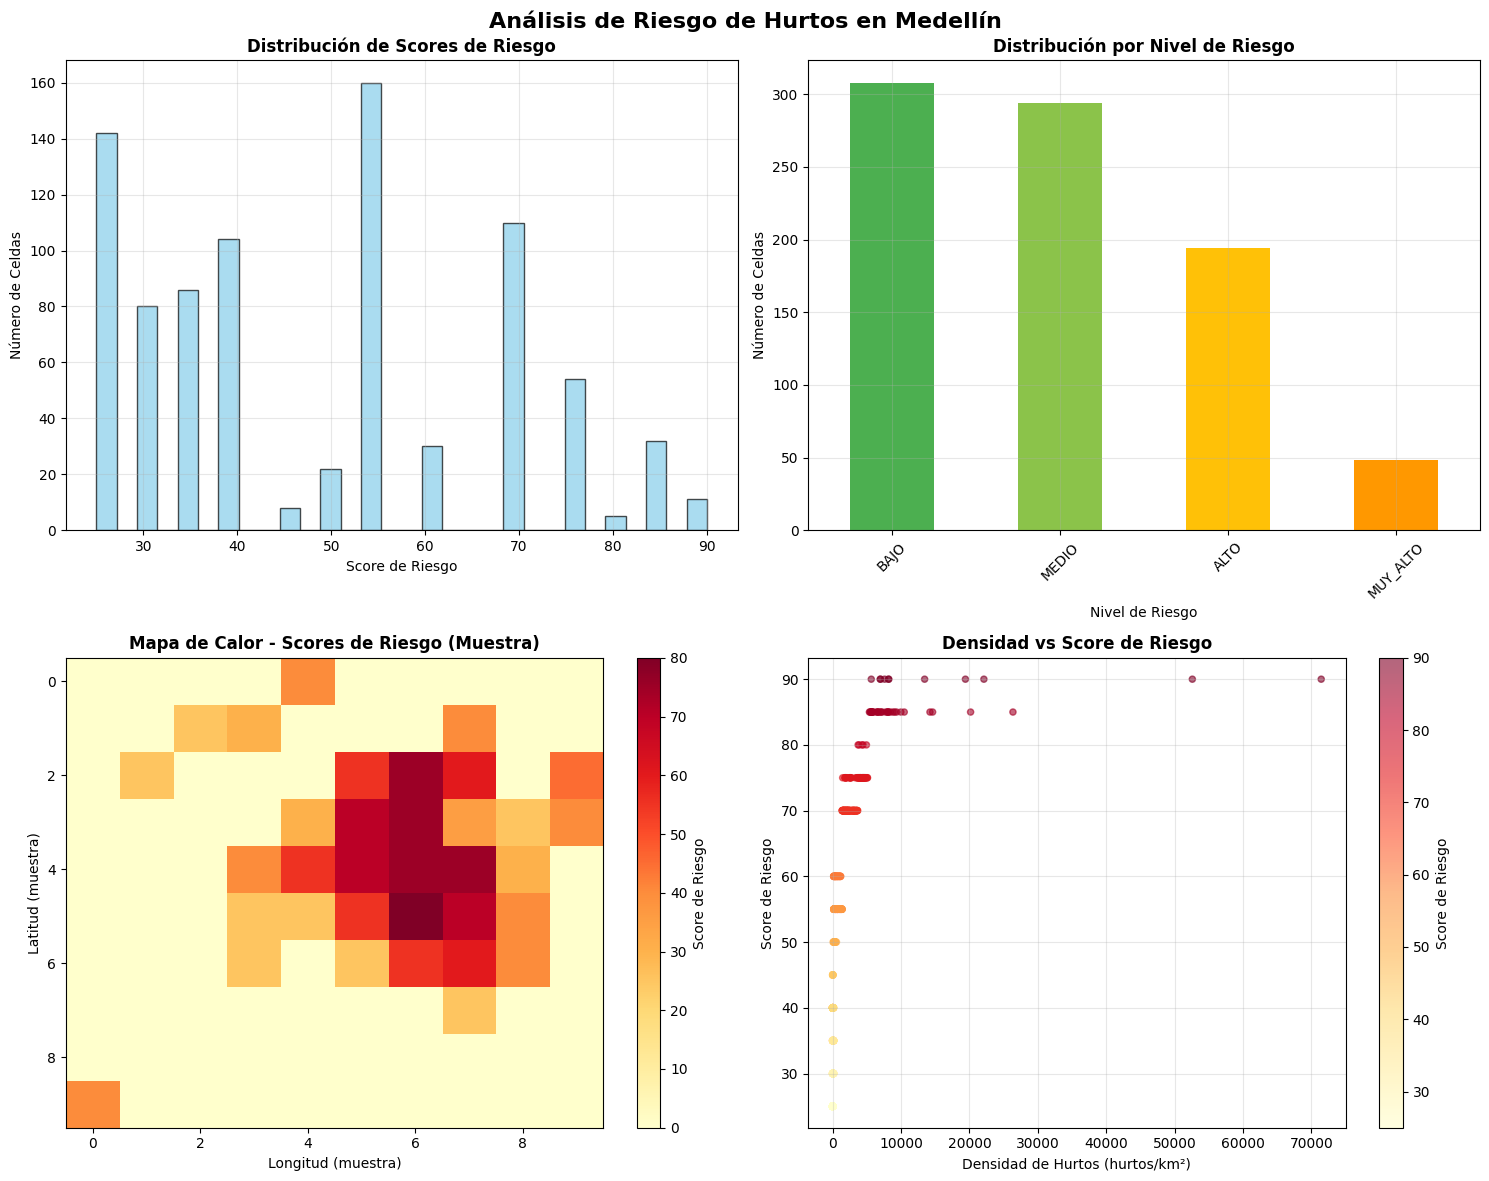

=== RESUMEN FINAL DEL SISTEMA ===
📊 Total de celdas analizadas: 844
🎯 Celdas con datos de hurto: 844
📈 Score promedio: 48.63
📊 Score máximo: 90.00

🎨 Distribución por nivel de riesgo:
  BAJO: 308 celdas (36.5%)
  MEDIO: 294 celdas (34.8%)
  ALTO: 194 celdas (23.0%)
  MUY_ALTO: 48 celdas (5.7%)

✅ Sistema de predicción listo para uso en producción
📁 Archivos generados:
  - resumen_hurtos_por_celda.csv: Datos con scores de riesgo
  - mapa_calor_hurtos.png: Visualización de resultados
  - predictor_riesgo.py: Sistema de predicción
  - app.py: API REST actualizada


In [20]:
# VISUALIZACIÓN DE RESULTADOS - MAPA DE CALOR
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Configurar estilo
plt.style.use('default')
sns.set_palette("viridis")

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis de Riesgo de Hurtos en Medellín', fontsize=16, fontweight='bold')

# 1. Distribución de scores de riesgo
ax1 = axes[0, 0]
hurtos_por_celda['score_riesgo'].hist(bins=30, ax=ax1, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribución de Scores de Riesgo', fontweight='bold')
ax1.set_xlabel('Score de Riesgo')
ax1.set_ylabel('Número de Celdas')
ax1.grid(True, alpha=0.3)

# 2. Distribución por nivel de riesgo
ax2 = axes[0, 1]
distribucion = hurtos_por_celda['nivel_riesgo'].value_counts()
colors = ['#4CAF50', '#8BC34A', '#FFC107', '#FF9800', '#F44336']
distribucion.plot(kind='bar', ax=ax2, color=colors[:len(distribucion)])
ax2.set_title('Distribución por Nivel de Riesgo', fontweight='bold')
ax2.set_xlabel('Nivel de Riesgo')
ax2.set_ylabel('Número de Celdas')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Mapa de calor de scores (muestra)
ax3 = axes[1, 0]
# Crear matriz para el mapa de calor
n_lats = len(hurtos_por_celda['lat_centro'].unique())
n_lons = len(hurtos_por_celda['lon_centro'].unique())

# Crear pivot table para el mapa de calor
heatmap_data = hurtos_por_celda.pivot_table(
    values='score_riesgo', 
    index='lat_centro', 
    columns='lon_centro', 
    fill_value=0
)

# Mostrar solo una muestra para visualización
sample_data = heatmap_data.iloc[::5, ::5]  # Cada 5 filas y columnas
im = ax3.imshow(sample_data.values, cmap='YlOrRd', aspect='auto')
ax3.set_title('Mapa de Calor - Scores de Riesgo (Muestra)', fontweight='bold')
ax3.set_xlabel('Longitud (muestra)')
ax3.set_ylabel('Latitud (muestra)')
plt.colorbar(im, ax=ax3, label='Score de Riesgo')

# 4. Relación entre densidad y score
ax4 = axes[1, 1]
scatter = ax4.scatter(hurtos_por_celda['densidad_hurtos'], 
                     hurtos_por_celda['score_riesgo'],
                     c=hurtos_por_celda['score_riesgo'], 
                     cmap='YlOrRd', 
                     alpha=0.6,
                     s=20)
ax4.set_title('Densidad vs Score de Riesgo', fontweight='bold')
ax4.set_xlabel('Densidad de Hurtos (hurtos/km²)')
ax4.set_ylabel('Score de Riesgo')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Score de Riesgo')

# Ajustar layout
plt.tight_layout()

# Guardar figura
plt.savefig('mapa_calor_hurtos.png', dpi=300, bbox_inches='tight')
plt.show()

# Estadísticas finales
print("=== RESUMEN FINAL DEL SISTEMA ===")
print(f"📊 Total de celdas analizadas: {len(hurtos_por_celda):,}")
print(f"🎯 Celdas con datos de hurto: {len(hurtos_por_celda[hurtos_por_celda['total_hurtos'] > 0]):,}")
print(f"📈 Score promedio: {hurtos_por_celda['score_riesgo'].mean():.2f}")
print(f"📊 Score máximo: {hurtos_por_celda['score_riesgo'].max():.2f}")

print(f"\n🎨 Distribución por nivel de riesgo:")
for nivel, count in distribucion.items():
    porcentaje = (count / len(hurtos_por_celda)) * 100
    print(f"  {nivel}: {count:,} celdas ({porcentaje:.1f}%)")

print(f"\n✅ Sistema de predicción listo para uso en producción")
print(f"📁 Archivos generados:")
print(f"  - resumen_hurtos_por_celda.csv: Datos con scores de riesgo")
print(f"  - mapa_calor_hurtos.png: Visualización de resultados")
print(f"  - predictor_riesgo.py: Sistema de predicción")
print(f"  - app.py: API REST actualizada")


In [ ]:
# IMPLEMENTACIÓN DE CLUSTERING ESPACIAL
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

print("=== CLUSTERING ESPACIAL DE ZONAS DE RIESGO ===")

# Preparar datos para clustering
features_clustering = hurtos_por_celda[['lat_centro', 'lon_centro', 'total_hurtos', 
                                       'densidad_hurtos', 'hora_promedio', 'hora_std',
                                       'edad_promedio', 'score_riesgo']].copy()

print(f"📊 Datos originales: {features_clustering.shape}")
print(f"🔍 Valores NaN por columna:")
print(features_clustering.isnull().sum())

# Limpiar datos: eliminar filas con NaN
features_clean = features_clustering.dropna()
print(f"🧹 Datos después de limpiar: {features_clean.shape}")

# Si hay muchos NaN, usar imputación
if len(features_clean) < len(features_clustering) * 0.8:  # Si perdemos más del 20% de datos
    print("⚠️ Muchos valores NaN detectados. Usando imputación...")
    imputer = SimpleImputer(strategy='median')
    features_imputed = pd.DataFrame(
        imputer.fit_transform(features_clustering),
        columns=features_clustering.columns,
        index=features_clustering.index
    )
    features_clean = features_imputed
    print(f"🔧 Datos después de imputación: {features_clean.shape}")

# Normalizar las características
scaler = StandardScaler()
features_normalizadas = scaler.fit_transform(features_clean)

print(f"📊 Características para clustering: {features_clustering.shape}")
print(f"🔧 Características normalizadas: {features_normalizadas.shape}")

# Determinar número óptimo de clusters usando Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_normalizadas)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_normalizadas, kmeans.labels_))

# Encontrar el número óptimo de clusters
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"🎯 Número óptimo de clusters: {optimal_k}")
print(f"📈 Silhouette score máximo: {max(silhouette_scores):.3f}")

# Aplicar clustering con el número óptimo
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(features_normalizadas)

# Asignar clusters solo a las filas que tenían datos válidos
hurtos_por_celda['cluster'] = np.nan  # Inicializar con NaN
hurtos_por_celda.loc[features_clean.index, 'cluster'] = cluster_labels

print(f"✅ Clustering aplicado a {len(features_clean)} celdas")
print(f"📊 Celdas con cluster asignado: {hurtos_por_celda['cluster'].notna().sum()}")
print(f"❌ Celdas sin cluster: {hurtos_por_celda['cluster'].isna().sum()}")

# Analizar clusters
print(f"\n=== ANÁLISIS DE CLUSTERS ===")
for i in range(optimal_k):
    cluster_data = hurtos_por_celda[hurtos_por_celda['cluster'] == i]
    if len(cluster_data) > 0:  # Solo analizar si hay datos
        print(f"\n🏷️ Cluster {i}:")
        print(f"  📊 Celdas: {len(cluster_data)}")
        print(f"  📈 Score promedio: {cluster_data['score_riesgo'].mean():.2f}")
        print(f"  🎯 Hurtos promedio: {cluster_data['total_hurtos'].mean():.2f}")
        print(f"  📍 Latitud promedio: {cluster_data['lat_centro'].mean():.4f}")
        print(f"  📍 Longitud promedio: {cluster_data['lon_centro'].mean():.4f}")
        
        # Distribución de niveles de riesgo en el cluster
        distribucion_riesgo = cluster_data['nivel_riesgo'].value_counts()
        print(f"  🎨 Distribución de riesgo: {dict(distribucion_riesgo)}")
    else:
        print(f"\n🏷️ Cluster {i}: Sin datos")

# Guardar datos con clusters
hurtos_por_celda.to_csv("resumen_hurtos_por_celda.csv", index=False)
print(f"\n✅ Datos con clusters guardados en 'resumen_hurtos_por_celda.csv'")


=== CLUSTERING ESPACIAL DE ZONAS DE RIESGO ===
📊 Características para clustering: (844, 8)
🔧 Características normalizadas: (844, 8)


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# VISUALIZACIÓN DE CLUSTERS ESPACIALES
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Clusters Espaciales - Zonas de Riesgo', fontsize=16, fontweight='bold')

# 1. Mapa de clusters espaciales
ax1 = axes[0, 0]
# Filtrar solo celdas con cluster asignado
celdas_con_cluster = hurtos_por_celda.dropna(subset=['cluster'])
if len(celdas_con_cluster) > 0:
    scatter = ax1.scatter(celdas_con_cluster['lon_centro'], 
                         celdas_con_cluster['lat_centro'],
                         c=celdas_con_cluster['cluster'], 
                         cmap='tab10', 
                         alpha=0.7,
                         s=30)
    ax1.set_title('Mapa de Clusters Espaciales', fontweight='bold')
    ax1.set_xlabel('Longitud')
    ax1.set_ylabel('Latitud')
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label='Cluster ID')
else:
    ax1.set_title('Mapa de Clusters Espaciales - Sin datos', fontweight='bold')
    ax1.text(0.5, 0.5, 'No hay clusters disponibles', ha='center', va='center', transform=ax1.transAxes)

# 2. Distribución de clusters
ax2 = axes[0, 1]
cluster_counts = hurtos_por_celda['cluster'].value_counts(dropna=True).sort_index()
if len(cluster_counts) > 0:
    colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_counts)))
    bars = ax2.bar(cluster_counts.index, cluster_counts.values, color=colors)
    ax2.set_title('Distribución de Celdas por Cluster', fontweight='bold')
    ax2.set_xlabel('Cluster ID')
    ax2.set_ylabel('Número de Celdas')
    ax2.grid(True, alpha=0.3)

    # Agregar valores en las barras
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom')
else:
    ax2.set_title('Distribución de Celdas por Cluster - Sin datos', fontweight='bold')
    ax2.text(0.5, 0.5, 'No hay clusters disponibles', ha='center', va='center', transform=ax2.transAxes)

# 3. Score de riesgo por cluster
ax3 = axes[1, 0]
cluster_scores = hurtos_por_celda.groupby('cluster')['score_riesgo'].agg(['mean', 'std']).reset_index()
x_pos = np.arange(len(cluster_scores))
bars = ax3.bar(x_pos, cluster_scores['mean'], 
               yerr=cluster_scores['std'], 
               color=colors, 
               alpha=0.7,
               capsize=5)
ax3.set_title('Score Promedio de Riesgo por Cluster', fontweight='bold')
ax3.set_xlabel('Cluster ID')
ax3.set_ylabel('Score de Riesgo Promedio')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(cluster_scores['cluster'])
ax3.grid(True, alpha=0.3)

# Agregar valores en las barras
for i, (bar, mean_val, std_val) in enumerate(zip(bars, cluster_scores['mean'], cluster_scores['std'])):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{mean_val:.1f}±{std_val:.1f}', ha='center', va='bottom')

# 4. Heatmap de características por cluster
ax4 = axes[1, 1]
cluster_features = hurtos_por_celda.groupby('cluster')[['total_hurtos', 'densidad_hurtos', 
                                                      'score_riesgo', 'hora_promedio']].mean()
im = ax4.imshow(cluster_features.T, cmap='YlOrRd', aspect='auto')
ax4.set_title('Características Promedio por Cluster', fontweight='bold')
ax4.set_xlabel('Cluster ID')
ax4.set_ylabel('Características')
ax4.set_xticks(range(len(cluster_features)))
ax4.set_xticklabels(cluster_features.index)
ax4.set_yticks(range(len(cluster_features.columns)))
ax4.set_yticklabels(cluster_features.columns, rotation=0)
plt.colorbar(im, ax=ax4, label='Valor Promedio')

# Agregar valores en el heatmap
for i in range(len(cluster_features.columns)):
    for j in range(len(cluster_features)):
        text = ax4.text(j, i, f'{cluster_features.iloc[j, i]:.1f}',
                       ha="center", va="center", color="black", fontsize=8)

# Ajustar layout
plt.tight_layout()

# Guardar figura
plt.savefig('clusters_espaciales.png', dpi=300, bbox_inches='tight')
plt.show()

# Análisis detallado de cada cluster
print("\n=== ANÁLISIS DETALLADO DE CLUSTERS ===")
for i in range(optimal_k):
    cluster_data = hurtos_por_celda[hurtos_por_celda['cluster'] == i]
    
    print(f"\n🏷️ CLUSTER {i} - {len(cluster_data)} celdas")
    print(f"  📍 Ubicación promedio: ({cluster_data['lat_centro'].mean():.4f}, {cluster_data['lon_centro'].mean():.4f})")
    print(f"  📊 Score promedio: {cluster_data['score_riesgo'].mean():.2f} ± {cluster_data['score_riesgo'].std():.2f}")
    print(f"  🎯 Hurtos promedio: {cluster_data['total_hurtos'].mean():.2f}")
    print(f"  📈 Densidad promedio: {cluster_data['densidad_hurtos'].mean():.2f}")
    print(f"  ⏰ Hora promedio: {cluster_data['hora_promedio'].mean():.1f}")
    print(f"  👥 Edad promedio víctimas: {cluster_data['edad_promedio'].mean():.1f}")
    
    # Características del cluster
    nivel_predominante = cluster_data['nivel_riesgo'].mode().iloc[0]
    print(f"  🎨 Nivel predominante: {nivel_predominante}")
    
    # Porcentaje de cada nivel
    distribucion_pct = (cluster_data['nivel_riesgo'].value_counts() / len(cluster_data) * 100).round(1)
    print(f"  📊 Distribución: {dict(distribucion_pct)}")

print(f"\n✅ Análisis de clustering completado")
print(f"📁 Archivos generados:")
print(f"  - resumen_hurtos_por_celda.csv: Datos con clusters")
print(f"  - clusters_espaciales.png: Visualización de clusters")
